<a href="https://colab.research.google.com/github/juansebastiangit/Inteligencia_artificial/blob/main/Proyecto/Adsorcion%20en%20superficies%20basado%20en%20RIUS%20V%201.1%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primera versión del intento de simulación de adsorción basado en el algoritmo de RIUS para pegar iones a superficies



# Hamiltoniano del sistema basico basado en el potencial de lennard-jones

$$ \textit{H}\left ( r_{ij} \right ) = 4\epsilon \left [ \left ( \frac{\sigma }{r_{ij}} \right )^{12}-\left ( \frac{\sigma }{r_{ij}} \right )^{6} \right] $$



# Librerias y Constantes

In [1]:
#Importamos ls librerias necesarias
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import tensorflow_probability as tfp

In [3]:
#Definimos las constantes a utilizar
a = 7.9 #Parametro de red (A)
SigmaAl = 3.302 #Radio de vanderwalls del aluminio (A)
EpsilonAl = 7.700e-3 #Fondo del pozo del aluminio (j/mol)
SigmaHg = 2.79 #Radio de vanderwalls del mercurio (A)
EpsilonHg = 10031 #Fondo del pozo mercurio (j/mol)
Sigma_I_L = np.sqrt(SigmaAl*SigmaHg)
Epsilon_I_L = np.sqrt(EpsilonAl*EpsilonHg)
Sigma_I_I = np.sqrt(SigmaHg*SigmaHg)
Epsilon_I_I = np.sqrt(EpsilonHg*EpsilonHg)

# Creación de la muestra

[[ 3.95  3.95  0.  ]
 [ 3.95  0.    3.95]
 [ 0.    3.95  3.95]
 ...
 [71.1  71.1  55.3 ]
 [71.1  71.1  63.2 ]
 [71.1  71.1  71.1 ]]
1003


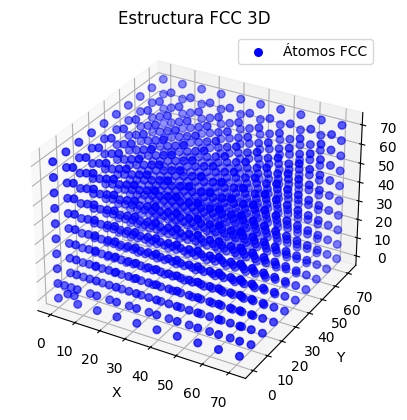

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensiones de la red FCC
celdas_largo = 10
celdas_alto = 10
celdas_profundidad = 10
a = 7.9  # Longitud de la celda unitaria

# Definir los vectores base de una celda unitaria FCC
base_fcc = np.array([[0.5, 0.5, 0], [0.5, 0, 0.5], [0, 0.5, 0.5]]) * a

# Crear las posiciones para las celdas unitarias
posiciones = list(base_fcc)
for i in range(celdas_largo):
    for j in range(celdas_alto):
        for k in range(celdas_profundidad):
          # Posiciones de átomos en cada celda FCC
          posiciones.append([i*a, j*a, k*a])

fcc_positions = np.array(posiciones)  # Matriz con posiciones FCC
num_atoms =fcc_positions.shape[0]
# Imprimir las posiciones
print (fcc_positions)
print(num_atoms)
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the FCC atoms
ax.scatter(fcc_positions[:, 0], fcc_positions[:, 1], fcc_positions[:, 2], s=30, color='blue', label="Átomos FCC")

# Customize the plot (optional)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Estructura FCC 3D')
ax.legend()

# Show the plot
plt.show()

# Creación de los iones que se van a adsorber

[[ 81.7495323   81.42520813  80.50530516]
 [-81.92741042 -81.20908166  80.69806159]
 [-80.31025691 -81.33800652 -81.46086689]]


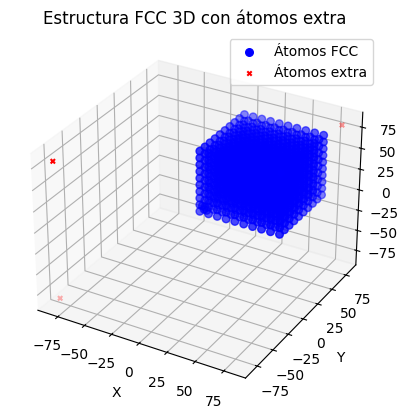

In [33]:
num_iones = 3  # Número de átomos extra que se colocarán al azar
x_lim = celdas_largo*a #Como es un cubo en general el limite es el mismo en todas las direcciones,
                      #Si tuviera dimensiones diferentes necesitaria y_lim y z_lim tambien

#Listas vacias para guardar las nuevas posiciones de los iones
x_extra=[]
y_extra=[]
z_extra=[]

# Generar átomos adicionales en posiciones aleatorias por fuera de la superficie de la muestra
for i in range(num_iones):
  if np.random.rand() < 0.5:
      x_extra.append(np.random.uniform(-(x_lim + 1*Sigma_I_L), -(x_lim + 0.3*Sigma_I_L)))
  else:
      x_extra.append(np.random.uniform(x_lim + 0.3*Sigma_I_L, x_lim + 1*Sigma_I_L))

  if np.random.rand() < 0.5:
      y_extra.append(np.random.uniform(-(x_lim + 1*Sigma_I_L), -(x_lim + 0.3*Sigma_I_L)))
  else:
      y_extra.append(np.random.uniform(x_lim + 0.3*Sigma_I_L, x_lim + 1*Sigma_I_L))

  if np.random.rand() < 0.5:
      z_extra.append(np.random.uniform(-(x_lim + 1*Sigma_I_L), -(x_lim + 0.3*Sigma_I_L)))
  else:
      z_extra.append(np.random.uniform(x_lim + 0.3*Sigma_I_L, x_lim + 1*Sigma_I_L))


extra_positions = np.column_stack((x_extra, y_extra, z_extra))  # Matriz con posiciones de átomos extra
print(extra_positions)
# Graficar las posiciones en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    fcc_positions[:, 0],
    fcc_positions[:, 1],
    fcc_positions[:, 2],
    color="blue",
    s=30,
    label="Átomos FCC",
)
ax.scatter(
    extra_positions[:, 0],
    extra_positions[:, 1],
    extra_positions[:, 2],
    color="red",
    s=10,
    marker='x',
    label="Átomos extra",
)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Estructura FCC 3D con átomos extra")
ax.legend()
plt.show()

In [34]:
@tf.function
# Potencial de Lennard-Jones
def lennard_jones_potential(r, epsilon, sigma):
    """
    Calcula el potencial de Lennard-Jones para una distancia r.
    """
    sigma = tf.cast(sigma, tf.float32)
    epsilon = tf.cast(epsilon, tf.float32)
    lj_term = (sigma / r)**12 - (sigma / r)**6
    return 4 * epsilon * lj_term + epsilon #Suma epsilon para desplazar el fondo del potencial a 0

# Función de costo para el modelo
def H_loss(Xh, Xt, epsilon_l=Epsilon_I_L, sigma_l=Sigma_I_L, epsilon_i=Epsilon_I_I, sigma_i=Sigma_I_I ):
    """
    Calcula la energía total de las interacciones entre los iones (Xh) y la superficie (Xt),
    utilizando el potencial de Lennard-Jones.

    Parameters:
        Xh: tensor con posiciones de los iones (num_iones, 2)
        Xt: tensor con posiciones de los átomos de la superficie (num_superficie, 2)

    Returns:
        Energía promedio del sistema (escalar)
    """
    #----------------------INTERACCIONES ION-NANOESTRUCTURA-------

    # Expandir dimensiones para obtener todas las combinaciones de distancias ion-atomo
    diff = tf.expand_dims(Xh, axis=1) - tf.expand_dims(Xt, axis=0)  # (num_iones, num_superficie, 2)
    r = tf.norm(diff, axis=-1)  # Distancia entre cada ion y cada átomo de la superficie (num_iones, num_superficie)

    # Evitar divisiones por cero
    r = tf.where(r == 0, 1e-10, r)

    # Calcular el potencial de Lennard-Jones para cada interacción ion atomo
    lj_energy = lennard_jones_potential(r, epsilon_l, sigma_l)  # (num_iones, num_superficie)

    # Energía total para cada ion
    ion_lattice_energy = tf.reduce_sum(lj_energy, axis=1)  # Suma sobre los átomos de la superficie (num_iones)

    #----------------------INTERACCIONES ION-ION-------
    ion_indices = tf.range(tf.shape(Xh)[0]) #Define los indices que identifican a cada ion
    ion_pairs = tf.stack(tf.meshgrid(ion_indices, ion_indices, indexing='ij'),axis=-1) #Define una estructura con todas las combinaciones posibles de indices, y las combina en un tensor
    ion_pairs = tf.reshape(ion_pairs, [-1, 2])
    ion_pairs = tf.boolean_mask(ion_pairs, ion_pairs[:,0] < ion_pairs[:,1])#Filtra las parejas dubplicadas y la pareja formada consigo mismo

    diff_ion_ion = tf.gather(Xh, ion_pairs[:,0]) - tf.gather(Xh, ion_pairs[:,1])
    r_ion_ion = tf.norm(diff_ion_ion, axis=-1)
    r_ion_ion = tf.where(r_ion_ion == 0, 1e-10, r_ion_ion)#Evita dividir por 0
    ion_ion_energy = tf.reduce_sum(lennard_jones_potential(r_ion_ion, epsilon_i, sigma_i))





    # Devolver la energía promedio del sistema
    energy_total = tf.reduce_mean(ion_lattice_energy + ion_ion_energy)# Promedio sobre los iones (escalar)
    #print(energy_total.shape)
    return energy_total

In [35]:
#tensorflow data
ion = tf.Variable(extra_positions,dtype=tf.float32)
sample_atoms = tf.convert_to_tensor(fcc_positions,dtype=tf.float32)
#lam_LJ = 0.4
#lam_ = tf.constant(lam_LJ,dtype=tf.float32)


In [36]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** epoch

In [37]:
# Callback class
class EarlyStoppingCallback:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = float('inf')
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                return True  # Signal to stop training
        return False  # Continue training

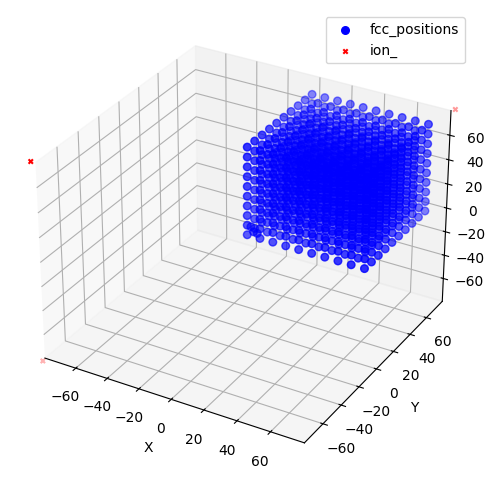

Epoch 1/200
Loss: 32158.310546875 MeanGrad: [2.9648376e-05 2.9184916e-05 2.7449039e-05]


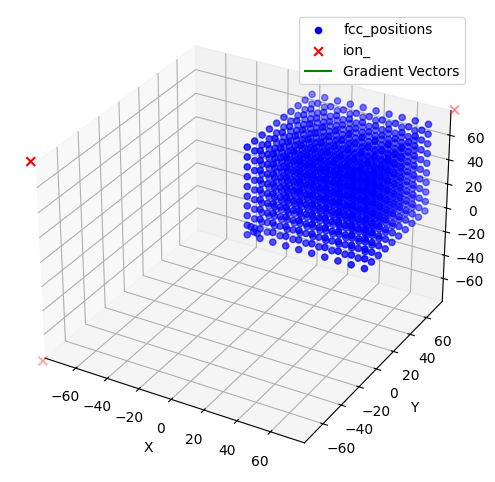

Epoch 2/200
Loss: 32158.310546875 MeanGrad: [1.4096398e-06 1.3509901e-06 1.6827980e-06]


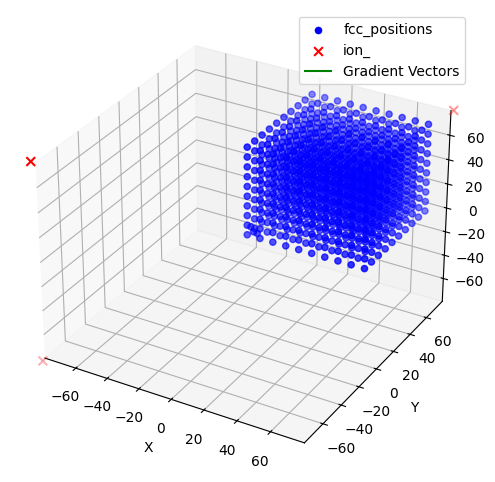

Epoch 3/200
Loss: 32158.310546875 MeanGrad: [4.1607225e-05 3.9707760e-05 3.6200872e-05]


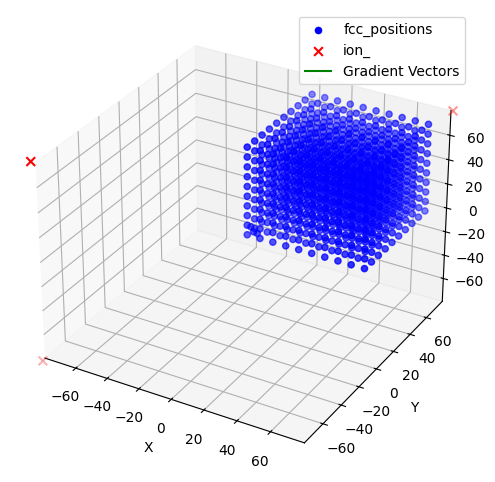

Epoch 4/200
Loss: 32158.310546875 MeanGrad: [1.6494882e-06 1.3313444e-06 1.6149025e-06]


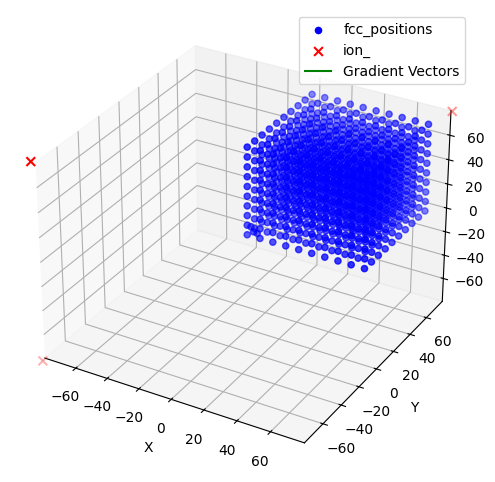

Epoch 5/200
Loss: 32158.310546875 MeanGrad: [7.4522463e-06 8.5524744e-06 1.1692579e-05]


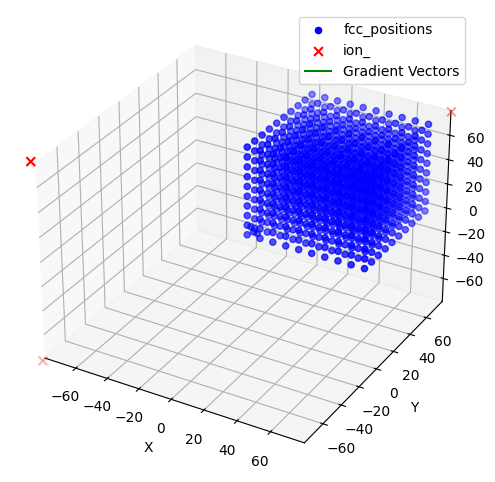

Epoch 6/200
Loss: 32158.310546875 MeanGrad: [1.0997222e-05 1.1762463e-05 1.4620706e-05]
Early stopping at epoch 6


In [38]:
ion_ =  ion.numpy()
fig = plt.figure(figsize=(6, 6))  # Adjust figure size if needed
ax = fig.add_subplot(111, projection='3d')

ax.scatter(fcc_positions[:, 0], fcc_positions[:, 1], fcc_positions[:, 2], c='b', s=30, label='fcc_positions')
ax.scatter(ion_[:, 0], ion_[:, 1], ion_[:, 2], c='r', s=40, marker='x', label='ion_')

ax.set_xlim([-(x_lim + 0.3*Sigma_I_L),x_lim + 0.3*Sigma_I_L])
ax.set_ylim([-(x_lim + 0.3*Sigma_I_L), x_lim + 0.3*Sigma_I_L])
ax.set_zlim([-(x_lim + 0.3*Sigma_I_L), x_lim + 0.3*Sigma_I_L])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()
# Custom training loop
eta0 = 0.1
batch_size = 256
epochs = 200
decay_rate = 0.20
optimizer = tf.keras.optimizers.Adam(learning_rate=eta0)
starting_pos =ion_.copy()

early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.0001)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
    #optimizer.learning_rate = eta
    for x_batch in tf.data.Dataset.from_tensor_slices(sample_atoms).shuffle(buffer_size=1024).batch(batch_size):

      with tf.GradientTape() as g:
        g.watch(ion)
        H_loss_ = H_loss(ion,x_batch)
      grad_ = g.gradient(H_loss_, ion)
      optimizer.apply_gradients(zip([grad_], [ion]))
    print(f'Loss: {H_loss_.numpy()} MeanGrad: {tf.math.reduce_mean(grad_,axis=0).numpy()}')

    # Call the callback's on_epoch_end method
    if early_stopping.on_epoch_end(epoch, H_loss_.numpy()):
        print(f'Early stopping at epoch {early_stopping.stopped_epoch + 1}')
        last_loss = H_loss_.numpy()
        system_energy = last_loss-(num_atoms*num_iones*Epsilon_I_L)
        break

    ion_ =  ion.numpy()
    gradN = -10*eta0*grad_.numpy()

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(fcc_positions[:, 0], fcc_positions[:, 1], fcc_positions[:, 2], c='b', s=20, label='fcc_positions')
    ax.scatter(ion_[:, 0], ion_[:, 1], ion_[:, 2], c='r', s=40, marker='x', label='ion_')

    # For quiver, we need to create a 3D representation of the gradient
    # Assuming gradN is a 2D array (num_ions, 2)
    gradN_3D = np.zeros(gradN.shape,dtype=gradN.dtype)  # Initialize with zeros for z-component
    gradN_3D = gradN  # Copy x and y components from gradN

    ax.quiver(ion_[:, 0], ion_[:, 1], ion_[:, 2], gradN_3D[:, 0], gradN_3D[:, 1], gradN_3D[:, 2],
              color='g', length=0.1, normalize=True, label='Gradient Vectors')  # Adjust length and normalize as needed

    ax.set_xlim([-(x_lim + 0.3*Sigma_I_L),x_lim + 0.3*Sigma_I_L])
    ax.set_ylim([-(x_lim + 0.3*Sigma_I_L), x_lim + 0.3*Sigma_I_L])
    ax.set_zlim([-(x_lim + 0.3*Sigma_I_L), x_lim + 0.3*Sigma_I_L])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    plt.show()

    if epoch+1==epochs:
      last_loss = H_loss_.numpy()
      system_energy = last_loss-(num_atoms*num_iones*Epsilon_I_L)

In [39]:
print(f'minima distancia para que no haya superposicion:{Sigma_I_L:.3f} A ',f'profundidad del pozo: {-Epsilon_I_L: .3f} j/mol')
print(f'Atomos en la muestra:{num_atoms}',f', Iones a adsorber:{num_iones}')
print(f'energía del sistema:{system_energy:.3f} j/mol',f'minima energía posible: {-Epsilon_I_L*num_atoms*num_iones:.3f} j/mol')
print(f'distance traveled: {ion_-starting_pos}')

minima distancia para que no haya superposicion:3.035 A  profundidad del pozo: -8.789 j/mol
Atomos en la muestra:1003 , Iones a adsorber:3
energía del sistema:5713.548 j/mol minima energía posible: -26444.762 j/mol
distance traveled: [[-1.5384674  -1.5183029  -1.5329895 ]
 [ 0.01154327  0.01067352 -0.07421112]
 [ 0.00172424  0.00254822  0.07430267]]
